In [1]:
## Perform clinical annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# clinical = clinical information associated with samples
# col = columns in clinical data on which the analysis will be performed
## OUPUTS: a list containing output values
# selectivity = Selectivity (fraction of significant annotations per all significant factors)
# nonZeroFacs = Number of unique factors that were significant at least once
# total_pathways = Number of clinical annotations with at least one significant factor component
##执行基于临床注释的比较
##输入：
#factorizations=已计算的因式分解
#clinical=与样本相关的临床信息
#col=将对其执行分析的临床数据列
##输出：包含输出值的列表
#selectivity=选择性（每个重要因素的重要注释分数）
#nonZeroFacs=至少一次显著的唯一因素的数量
#total_pathways=至少有一个显著因子成分的临床注释数
clinical_comparison <- function(factorizations, clinical, col){

    # Empty containers
    line <- numeric(0)
    line2 <- numeric(0)
    line3 <- numeric(0)

    # For each factorization
    for(i in 1:length(factorizations)){

        # Extract sample association
        factors <- factorizations[[i]][[1]]
        if(is.null(names(factors))) { names(factors) <- 1:ncol(factors) }
        if(is.null(colnames(factors))) { colnames(factors) <- 1:ncol(factors) }

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(clinical[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.clinical.data <- clinical[indices,]        
        
        # Only use column names that are really present in the data
        col_new <- col[col %in% colnames(ordered.clinical.data)]

        # Stor all p-values
        pvalues <- numeric(0)
        # Store number of significant annotations
        clin_erich <- 0 
        
        # Test significance association with clinical annotations
        for(j in col_new){
            
            # Perform the analysis if there is more than one possible value in current column
            table_values <- table(ordered.clinical.data[,j])
            if(sum(table_values>0)>1){

                if(j == "age_at_initial_pathologic_diagnosis" ){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]),
                                                                      5, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "days_to_new_tumor_event_after_initial_treatment"){
                    pvalues_col <- apply(factors,MARGIN=2, 
                                       function(x) kruskal.test(x~cut(as.numeric(ordered.clinical.data[,j]), 
                                                                      3, include.lowest=TRUE))$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }else if(j == "gender" || j == "history_of_neoadjuvant_treatment"){
                    pvalues_col <- apply(factors, MARGIN=2, 
                                       function(x) wilcox.test(x~ordered.clinical.data[,j])$p.value)
                    pvalues <- c(pvalues, pvalues_col)
                    if(min(pvalues_col)<0.05){
                        clin_erich <- clin_erich+1
                    }
                }
            }
        }
        
        # Number of clinical annotations with at least one significant p-value
        line3 <- rbind(line3, clin_erich)

        # Total number of significant factors in all tested columns
        column <- names(pvalues)[pvalues<0.05]
        # Number of unique factors that were significant at least once
        line2<-rbind(line2, length(unique(column)))

        # Number of times a p-value was found significant
        signif <- length(column)
        f<-length(unique(column))                                 
        # Selectivity 
        if(signif!=0){
            line <- rbind(line,((clin_erich/signif)+(f/signif))/2)
        }else{
            line <- rbind(line,0)
        }

    }
    
    # Store and return results
    out <- data.frame(selectivity=line, nonZeroFacs=line2, total_pathways=line3)
#    print(out)
    return(out)
}

In [2]:
library('survival')

## Perform survival annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# method = methods used for factorization
# survival = survival data associated to the cancer
# out.folder = folder where results will be written
# cancer = name of currently analysed cancer
## OUPUTS: a list containing output values

##执行基于注释的比较
##输入：
#factorizations=已计算的因式分解
#method=用于因子分解的方法
#survival=与癌症相关的生存数据
# out.folder文件夹=将写入结果的文件夹
#cancer=当前分析癌症的名称
##输出：包含输出值的列表
survival_comparison <- function(factorizations, method, survival, out.folder, cancer){
    
    # Initialize result containers
    factors_cancer <- numeric(0)
    surv_final <- numeric(0)
    
    # Adjust sample names for breast survival dataset
    if(cancer=="breast"){survival[,1] <- paste0(survival[,1],"-01")}
    
    # For each computed factorisation
    for(i in 1:length(factorizations)){

        # Extract sample factors 
        factors <- factorizations[[i]][[1]]

        # Patient names in factorisation results
        patient.names <- rownames(factors)
        # Patient names in original data
        patient.names.in.file <- as.character(survival[, 1])
        patient.names.in.file <- toupper(gsub('-', '\\.', patient.names.in.file))
        # Remove non-matching patient names
        is_in_file <- patient.names %in% patient.names.in.file
        if(length(patient.names)!=sum(is_in_file)) {
            factors <- factors[is_in_file, ]
            patient.names <- patient.names[is_in_file]
            rownames(factors)<-patient.names
        }
        # Match indices of patient names
        indices <- match(patient.names, patient.names.in.file)
        # Use indices to extract coresponding survival information
        ordered.survival.data <- survival[indices,]
        # Clean data (assign 0 to NAs)
        ordered.survival.data$Survival[is.na(ordered.survival.data$Survival)] <- 0
        ordered.survival.data$Death[is.na(ordered.survival.data$Death)] <- 0

        # Calculate coxph
        coxph_obj <- coxph(Surv(ordered.survival.data$Survival, ordered.survival.data$Death) ~ factors)
        # P-values (corrected by the number of methods)
        pvalues <- length(factorizations)*as.matrix(coef(summary(coxph_obj))[,5])

        # How many significant? 
        factors_cancer <- c(factors_cancer, sum(pvalues<0.05))
        # Store p-values
        surv_final <- cbind(surv_final, pvalues) 
    }
    # Keep -log10 of p-values
    surv_final<-(-log10(surv_final))
    # Plot survival pvalues for each cancer type separately
    png(file=paste0(out.folder, "survival_", cancer, ".png"), width = 15, height = 15, units = 'in', res = 200)
    matplot(1:length(method), t(surv_final), 
            col="black", pch=18, xlab="Method", ylab="Pvalues survival", xaxt="none", cex=1.5)
    abline(h = (-log10(0.05)), v=0, col="black", lty=3, lwd=3)
    #axis(1, at=1:length(method), labels=colnames(surv_final)) 
    axis(1, at=c("AE_FAETC","AE_FCTAE","DAE_FAETC","DAE_FCTAE","VAE_FCTAE","LSTMVAE_FCTAE"), labels=colnames(surv_final)) 
    
    dev.off()

#    print(factors_cancer)
    return(factors_cancer)
}

In [3]:
library("fgsea", quietly = TRUE)

## Perform biological annotation-based comparison 
## INPUTS:
# factorizations = already computed factirizations
# path.database = path to a GMT annotation file
# pval.thr = p-value threshold (default to 0.05)
## OUPUTS: a list containing output values
# selectivity = Selectivity (fraction of significant annotations per all significant factors)
# nonZeroFacs = Number of unique factors that were significant at least once
# total_pathways = Number of clinical annotations with at least one significant factor component
biological_comparison <- function(factorizations, path.database, pval.thr=0.05){
    
    # Load annotation database
    pathways <- gmtPathways(path.database)
    
    # Containers to report results
    report_number <- numeric(0)
    report_nnzero <- numeric(0)
    report_select <- numeric(0)
    
    # For each factorization method
    for(i in 1:length(factorizations)){
        
        # Extract metagenes found by factorization method
        metagenes<-factorizations[[i]][[2]][[1]]
        # Number of factors
        num.factors <- ncol(metagenes)
        # Rename columns
        colnames(metagenes)<-1:num.factors
        # Rename rows to remove "|" characters and keep only the gene name before
        rownames(metagenes)<-gsub("\\|",".",rownames(metagenes))
        rownames(metagenes)<-gsub("\\..*","",rownames(metagenes))
        # Remove duplicated gene names that could confuse fgsea
        duplicated_names <- unique(rownames(metagenes)[duplicated(rownames(metagenes))])
        metagenes <- metagenes[!(rownames(metagenes) %in% duplicated_names), ]

        # Variables
        min_pval <- numeric(0)
        path <- numeric(0)
        n <- 0
        
        # Calculate biological annotation enrichment.
        # For each factor,
        for(j in 1:num.factors){
            # Assign gene names
            rnk <- setNames(as.matrix(metagenes[,j]), rownames(metagenes))
            # Compute fgsea
            fgseaRes <- fgsea(pathways, rnk, minSize=15, maxSize=500, nperm=1000)
            # If at least one pathway is significant
            if(sum(fgseaRes$padj < pval.thr)!=0){
                # Count this factor
                n <- n+1
                # Keep min adjusted p-value
                min_pval <- rbind(min_pval, min(fgseaRes$padj))
                # Keep names of significant pathways
                path <- c(path, fgseaRes[fgseaRes$padj<pval.thr, "pathway"])
            } else {
                min_pval <- rbind(min_pval, NA)
            }
        }

        # Report number of unique significant pathways  
        if(length(path)==0){
            report_number <- rbind(report_number, 0)
        }else{
            report_number <- rbind(report_number, length(unique(path)))
        }
        # Report selectivity 
        if(length(unique(path))==0){
            report_select <- rbind(report_select, NA)
        }else{
            al<-length(unique(path))/length(path)
            fl<-length(which(!is.na(min_pval)))/length(path)
            report_select <- rbind(report_select, (al+fl)/2)
        }
        # Report number of factors associated with at least one significant pathway
        report_nnzero<-rbind(report_nnzero, n)    
    
    }
    
    out <- data.frame(selectivity=report_select, nonZeroFacs=report_nnzero, total_pathways=report_number)
#    print(out)
    return(out)
}

In [18]:
# Load the function running the factorization, plus a support function
source("runfactorization.R")
source("log2matrix.R")

# List downloaded cancer data.
# Folder structure should be organized as discussed above.
# Exclude first result as it's the parent folder
# cancers <- list.dirs(path = "../data/cancertest", full.names = TRUE, recursive = TRUE)[-1]
# cancer_names <- list.dirs(path = "../data/cancertest", full.names = FALSE, recursive = TRUE)[-1]

cancers <- list.dirs(path = "../data/cancer3", full.names = TRUE, recursive = TRUE)[-1]
cancer_names <- list.dirs(path = "../data/cancer3", full.names = FALSE, recursive = TRUE)[-1]

# Annotation databases used for biological enrichment
path.database <- "../data/bio_annotations/c2.cp.reactome.v6.2.symbols.gmt" #REACTOME
#path.database <- "../data/bio_annotations/h.all.v6.2.symbols.gmt" #Hallmarks
#path.database <- "../data/bio_annotations/c5.all.v6.2.symbols.gmt" #GO

# Label to identify current run
tag <- format(Sys.time(), "%Y%m%d%H%M%S")
# Folder for comparison results
results_folder <- paste0("../results", tag, "/")
# Create output folder
dir.create(results_folder, showWarnings = FALSE)

# Number of factors used in the paper
num.factors <- 10

# Initialize result containers
clinical_analysis <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)

biological_analysis <- data.frame(
    matrix(data = NA, ncol=5, nrow=0, 
           dimnames = list(c(), c("methods", "cancer", "selectivity", "nonZeroFacs", "total_pathways"))
          ),
    stringsAsFactors = FALSE)
cancer.list <- list()

# Clinical categories to be used for clinical tests
col <- c("age_at_initial_pathologic_diagnosis",
         "gender",
         "days_to_new_tumor_event_after_initial_treatment",
         "history_of_neoadjuvant_treatment")

In [19]:
print(cancers)

[1] "../data/cancer3/aml"      "../data/cancer3/breast"  
[3] "../data/cancer3/colon"    "../data/cancer3/kidney"  
[5] "../data/cancer3/melanoma" "../data/cancer3/ovarian" 
[7] "../data/cancer3/sarcoma" 


In [10]:
mode(cancers)

[1] "character"

In [ ]:
method<-c("AE_FAETC","AE_FCTAE","DAE_FAETC","DAE_FCTAE","VAE_FCTAE","LSTMVAE_FCTAE")

In [14]:
factorizations<-list()
factorization1=read.table(paste("../data/cancer/aml","/AE_FAETC_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[1]]<-list(factorization1)

factorization2=read.table(paste("../data/cancer/aml","/AE_FCTAE_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[2]]<-list(factorization2)

factorization3=read.table(paste("../data/cancer/aml","/DAE_FAETC_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[3]]<-list(factorization3)

factorization4=read.table(paste("../data/cancer/aml","/DAE_FCTAE_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[4]]<-list(factorization4)

factorization5=read.table(paste("../data/cancer/aml","/VAE_FCTAE_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[5]]<-list(factorization5)

factorization6=read.table(paste("../data/cancer/aml","/LSTMVAE_FCTAE_EM.txt",sep=""), sep=" ", header=FALSE)
factorizations[[6]]<-list(factorization6)

In [15]:
factorizations

[[1]]
[[1]][[1]]
             V1          V2          V3          V4          V5           V6
1     2.8810773  10.4066467 -14.0121717 -16.1973343  2.99997973  -3.28695488
2     0.7618766 -17.2627048 -17.8810635  -5.1482120  2.05735373  -2.69763494
3   -22.0414429  13.2924080 -20.4009438  -6.8802342  1.57084727  -5.62033463
4   -15.9062243  -6.0755281  -2.7504244 -25.9804878  2.58203697  -4.04373646
5    -3.7934496 -18.9399719   9.6689863  -5.8095994  2.95855689   0.36943522
6     8.6433077 -12.8703737   8.6739178 -13.7521105  4.24764538  -0.90084100
7     6.0459995 -17.9827328   0.9702364  -2.7191286  3.57151914  -0.69291496
8   -11.7564793  15.4424181  -1.2085484 -20.2516747  1.30802357  -3.90948176
9    -9.8515005  -9.4869318 -28.4124413 -10.5977449  3.41181397  -1.69388366
10    4.4796090   1.4532874  -2.9662538 -22.8153496  2.59712577  -3.83219862
11   10.7486391  -5.2633023   0.2724830 -16.3350925  0.65014857  -0.45966139
12  -11.5708399   6.7627220 -24.4341812 -20.0528641  1.86413622  -3.78065848
13   -2.2730594  -8.4899645   6.0248337 -23.6696281  1.99959445  -1.16015720
14   -2.8928783 -11.3737040 -18.6095123  -3.2508230  2.16707635  -4.38314629
15   -3.3590488  -1.8937924 -32.9735031 -12.8889933  4.15582418  -1.41112590
16  -30.9378738   1.7613243  -6.3716621 -16.7008934 -0.04121362  -5.74209213
17   -9.0478525 -17.5919476 -20.7273540 -11.8613539  5.54359484  -0.95356190
18   -1.8827852  -8.2875710  -0.7625901   8.0340633 -5.25211763  -2.83894515
19  -22.5084686  -1.8624849   4.3601685 -13.2048407  1.93291223  -5.67960644
20    8.0968018  -2.0970933   7.6349835 -16.5521851  1.06931818  -0.99831378
21   -0.9910342  -9.1098661  12.1566858 -10.8197107  4.38272333   0.80793512
22    5.4620419   4.5510702  -2.5678735 -18.4366798  1.17657280  -1.99174750
23  -19.1713276  -8.7833776 -25.3688431 -18.4441986  1.10126388  -4.19294453
24   -4.0674348  -3.9719660  11.1022062  -1.1719444  2.76013970  -2.41866183
25    3.9922876  11.9451733  -5.4594603 -16.4292336  2.80215144  -3.01875377
26  -10.6386843   4.5776911   1.2790424 -21.1476822  5.07387447  -4.19957924
27   -1.1679879   2.9606979   9.1321135 -15.2227564  0.94201237  -1.25721633
28    1.9073864 -10.3060808   1.8309432 -25.3001938  1.37544882  -0.84014308
29    6.2155695  -2.5128734   4.7434921 -21.9948273  1.01232171  -0.75826967
30  -23.4135914  10.3590307  -9.4712906 -18.2724915  0.67126894  -4.39304829
31    6.6427479 -19.2966347 -15.7051582 -12.4255114  2.31092191  -0.76654005
32   -9.8574238 -12.2706013   0.7193223   3.3603530 -4.87996960  -4.66546106
33   -8.1492834 -10.6959829   6.3302803  -1.3423165 -2.27055311  -3.23763156
34   -6.9354935  -2.7289889  10.4162569 -13.1065226  4.10248280  -3.64786744
35   -4.0408916   9.1747675 -23.0836792 -19.6905918  1.71580422  -6.17434120
36   -8.9165621 -14.3957968  -1.6198319 -24.7290535  3.43164444  -2.37455487
37   -9.5391397 -13.0384378 -17.0727062 -30.7911339  1.49861634  -3.47890162
38    2.5271330  -0.9241640  -8.5590391 -23.4485817  1.15346408  -1.98336875
39  -23.9280624  -3.2763879 -29.5573196  -7.4326172  0.98909563  -4.58632135
40   -8.0295324 -19.5775394  10.1484518 -17.3347893  0.93927294   0.84600794
41  -16.1130810  -1.6938165 -17.6905289   7.6349587  7.68667269  -3.37444806
42    8.7725439  -7.8472652   0.6762611 -24.6284218  0.10192093  -1.14389741
43    5.7066870 -18.9729176   1.9341124 -11.3677168  1.92261720  -1.32142186
44  -19.2741833  18.5082951  -3.2296629 -14.1125984  3.38012695  -6.95274305
45   -3.5244951 -22.5767059 -10.0152779 -17.7352772  2.87969851  -2.25400019
46   -1.3037399 -16.9141808  -2.0552263 -27.5729179  2.68814421  -3.31199908
47  -28.6823044  10.8591852  -9.7051172  -5.3425899  0.74864179  -8.82544422
48   -0.2223512 -12.1761198 -22.9741554 -10.4440260  2.26283979  -3.04703808
49  -16.9461346   7.9159288 -15.1622772 -16.8464584  1.35470331  -5.83168697
50   -6.3933907   6.9429183  12.1989422  -8.7681742  2.39158010  -4.83524418
51  -12.6143541 -15.7847643  -8.0598516   6.0233197  1.0

[[1]]
             V1          V2          V3          V4          V5           V6
1     2.8810773  10.4066467 -14.0121717 -16.1973343  2.99997973  -3.28695488
2     0.7618766 -17.2627048 -17.8810635  -5.1482120  2.05735373  -2.69763494
3   -22.0414429  13.2924080 -20.4009438  -6.8802342  1.57084727  -5.62033463
4   -15.9062243  -6.0755281  -2.7504244 -25.9804878  2.58203697  -4.04373646
5    -3.7934496 -18.9399719   9.6689863  -5.8095994  2.95855689   0.36943522
6     8.6433077 -12.8703737   8.6739178 -13.7521105  4.24764538  -0.90084100
7     6.0459995 -17.9827328   0.9702364  -2.7191286  3.57151914  -0.69291496
8   -11.7564793  15.4424181  -1.2085484 -20.2516747  1.30802357  -3.90948176
9    -9.8515005  -9.4869318 -28.4124413 -10.5977449  3.41181397  -1.69388366
10    4.4796090   1.4532874  -2.9662538 -22.8153496  2.59712577  -3.83219862
11   10.7486391  -5.2633023   0.2724830 -16.3350925  0.65014857  -0.45966139
12  -11.5708399   6.7627220 -24.4341812 -20.0528641  1.86413622  -3.78065848
13   -2.2730594  -8.4899645   6.0248337 -23.6696281  1.99959445  -1.16015720
14   -2.8928783 -11.3737040 -18.6095123  -3.2508230  2.16707635  -4.38314629
15   -3.3590488  -1.8937924 -32.9735031 -12.8889933  4.15582418  -1.41112590
16  -30.9378738   1.7613243  -6.3716621 -16.7008934 -0.04121362  -5.74209213
17   -9.0478525 -17.5919476 -20.7273540 -11.8613539  5.54359484  -0.95356190
18   -1.8827852  -8.2875710  -0.7625901   8.0340633 -5.25211763  -2.83894515
19  -22.5084686  -1.8624849   4.3601685 -13.2048407  1.93291223  -5.67960644
20    8.0968018  -2.0970933   7.6349835 -16.5521851  1.06931818  -0.99831378
21   -0.9910342  -9.1098661  12.1566858 -10.8197107  4.38272333   0.80793512
22    5.4620419   4.5510702  -2.5678735 -18.4366798  1.17657280  -1.99174750
23  -19.1713276  -8.7833776 -25.3688431 -18.4441986  1.10126388  -4.19294453
24   -4.0674348  -3.9719660  11.1022062  -1.1719444  2.76013970  -2.41866183
25    3.9922876  11.9451733  -5.4594603 -16.4292336  2.80215144  -3.01875377
26  -10.6386843   4.5776911   1.2790424 -21.1476822  5.07387447  -4.19957924
27   -1.1679879   2.9606979   9.1321135 -15.2227564  0.94201237  -1.25721633
28    1.9073864 -10.3060808   1.8309432 -25.3001938  1.37544882  -0.84014308
29    6.2155695  -2.5128734   4.7434921 -21.9948273  1.01232171  -0.75826967
30  -23.4135914  10.3590307  -9.4712906 -18.2724915  0.67126894  -4.39304829
31    6.6427479 -19.2966347 -15.7051582 -12.4255114  2.31092191  -0.76654005
32   -9.8574238 -12.2706013   0.7193223   3.3603530 -4.87996960  -4.66546106
33   -8.1492834 -10.6959829   6.3302803  -1.3423165 -2.27055311  -3.23763156
34   -6.9354935  -2.7289889  10.4162569 -13.1065226  4.10248280  -3.64786744
35   -4.0408916   9.1747675 -23.0836792 -19.6905918  1.71580422  -6.17434120
36   -8.9165621 -14.3957968  -1.6198319 -24.7290535  3.43164444  -2.37455487
37   -9.5391397 -13.0384378 -17.0727062 -30.7911339  1.49861634  -3.47890162
38    2.5271330  -0.9241640  -8.5590391 -23.4485817  1.15346408  -1.98336875
39  -23.9280624  -3.2763879 -29.5573196  -7.4326172  0.98909563  -4.58632135
40   -8.0295324 -19.5775394  10.1484518 -17.3347893  0.93927294   0.84600794
41  -16.1130810  -1.6938165 -17.6905289   7.6349587  7.68667269  -3.37444806
42    8.7725439  -7.8472652   0.6762611 -24.6284218  0.10192093  -1.14389741
43    5.7066870 -18.9729176   1.9341124 -11.3677168  1.92261720  -1.32142186
44  -19.2741833  18.5082951  -3.2296629 -14.1125984  3.38012695  -6.95274305
45   -3.5244951 -22.5767059 -10.0152779 -17.7352772  2.87969851  -2.25400019
46   -1.3037399 -16.9141808  -2.0552263 -27.5729179  2.68814421  -3.31199908
47  -28.6823044  10.8591852  -9.7051172  -5.3425899  0.74864179  -8.82544422
48   -0.2223512 -12.1761198 -22.9741554 -10.4440260  2.26283979  -3.04703808
49  -16.9461346   7.9159288 -15.1622772 -16.8464584  1.35470331  -5.83168697
50   -6.3933907   6.9429183  12.1989422  -8.7681742  2.39158010  -4.83524418
51  -12.6143541 -15.7847643  -8.0598516   6.0233197  1.05058146  -3

In [82]:
omicstemp<-as.matrix(read.table(paste("../data/cancer/aml","/log_exp",sep=""), sep=" ",row.names=1, header=T))

In [87]:
colnames(omicstemp)[1]<-substring(colnames(omicstemp)[1],7,)

In [98]:
mode(colnames(omicstemp))

[1] "character"

In [114]:
print(strsplit(colnames(omicstemp),split=' '))

[[1]]
[1] "TCGA.AB.2803.03"

[[2]]
[1] "TCGA.AB.2805.03"

[[3]]
[1] "TCGA.AB.2806.03"

[[4]]
[1] "TCGA.AB.2807.03"

[[5]]
[1] "TCGA.AB.2808.03"

[[6]]
[1] "TCGA.AB.2810.03"

[[7]]
[1] "TCGA.AB.2811.03"

[[8]]
[1] "TCGA.AB.2812.03"

[[9]]
[1] "TCGA.AB.2813.03"

[[10]]
[1] "TCGA.AB.2814.03"

[[11]]
[1] "TCGA.AB.2815.03"

[[12]]
[1] "TCGA.AB.2816.03"

[[13]]
[1] "TCGA.AB.2817.03"

[[14]]
[1] "TCGA.AB.2818.03"

[[15]]
[1] "TCGA.AB.2819.03"

[[16]]
[1] "TCGA.AB.2820.03"

[[17]]
[1] "TCGA.AB.2821.03"

[[18]]
[1] "TCGA.AB.2822.03"

[[19]]
[1] "TCGA.AB.2823.03"

[[20]]
[1] "TCGA.AB.2824.03"

[[21]]
[1] "TCGA.AB.2825.03"

[[22]]
[1] "TCGA.AB.2826.03"

[[23]]
[1] "TCGA.AB.2828.03"

[[24]]
[1] "TCGA.AB.2830.03"

[[25]]
[1] "TCGA.AB.2832.03"

[[26]]
[1] "TCGA.AB.2833.03"

[[27]]
[1] "TCGA.AB.2834.03"

[[28]]
[1] "TCGA.AB.2835.03"

[[29]]
[1] "TCGA.AB.2836.03"

[[30]]
[1] "TCGA.AB.2837.03"

[[31]]
[1] "TCGA.AB.2838.03"

[[32]]
[1] "TCGA.AB.2839.03"

[[33]]
[1] "TCGA.AB.2840.03"

[[34]]
[1] "TCGA.AB

In [20]:
# For each cancer dataset
for(i in cancers){

    print(paste0("Now analysing ", i))
    method<-c("AE_FAETC","AE_FCTAE","DAE_FAETC","DAE_FCTAE","VAE_FCTAE","LSTMVAE_FCTAE")
    #omicstemp<-as.matrix(read.table(paste(i,"/log_exp",sep=""), sep=" ",row.names=1, header=T))
    
    factorizations<-list()
    factorization=as.matrix(read.table(paste(i,"/AE_FAETC_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[1]]<-list(factorization)
    
    factorization=as.matrix(read.table(paste(i,"/AE_FCTAE_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[2]]<-list(factorization)
    
    factorization=as.matrix(read.table(paste(i,"/DAE_FAETC_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[3]]<-list(factorization)
    
    factorization=as.matrix(read.table(paste(i,"/DAE_FCTAE_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[4]]<-list(factorization)
    
    factorization=as.matrix(read.table(paste(i,"/VAE_FCTAE_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[5]]<-list(factorization)
    
    factorization=as.matrix(read.table(paste(i,"/LSTMVAE_FCTAE_EM_add_name.txt",sep=""), sep=" ",
                                        row.names=1,
                                        header=FALSE))
    factorizations[[6]]<-list(factorization)
    #print(factorizations)



    # Name of current cancer
    current_cancer <- basename(i)

    # If the expression and miRNA data are not log2-transformed as for those provided by XX et al.
    #log2matrix(i,"exp")
    #log2matrix(i,"mirna")

    # Perform factorisation
    #print("Running factorisation...")
    #out <- runfactorization(i, c("log_exp","methy","log_mirna"), num.factors, sep=" ", filtering="sd")
    
    # Survival analysis
    print("Running survival analysis...")
    survival <- read.table(paste0(i, "/survival"), sep="\t", header=TRUE, stringsAsFactors=FALSE)
    out_survival <- survival_comparison(factorizations, method, survival, 
                                        results_folder, current_cancer)
    
    # Clinical analysis
    print("Running clinical analysis...")
    clinical <- read.table(paste0("../data/clinical/", current_cancer), sep="\t", header=TRUE)
    out_clinical <- clinical_comparison(factorizations, clinical, col)   
    clinical_analysis <- rbind(clinical_analysis,
                                data.frame(methods=method, cancer=current_cancer, out_clinical))    

    # Biological analysis
#     print("Running biological analysis...")
#     out_bio <- biological_comparison(factorizations, path.database, pval.thr=0.05)
#     biological_analysis <- rbind(biological_analysis,
#                                 data.frame(methods=method, cancer=current_cancer, out_bio))    
}
rownames(clinical_analysis) <- c()
rownames(biological_analysis) <- c()

[1] "Now analysing ../data/cancer3/aml"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/breast"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/colon"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/kidney"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/melanoma"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/ovarian"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."
[1] "Now analysing ../data/cancer3/sarcoma"
[1] "Running survival analysis..."
[1] "Running clinical analysis..."


In [16]:
factorizations[[1]]

[[1]]
                         V2         V3           V4           V5           V6
TCGA.3B.A9HI.01  11.1992016  2.0343671 -12.50944710  19.68490028  0.838470876
TCGA.3B.A9HJ.01  -5.2070169 12.3819990   7.25596952  12.01733398  2.737030983
TCGA.3B.A9HL.01  11.6743784  1.9218457   0.03561664  13.03560829  1.314838171
TCGA.3B.A9HO.01  -2.1035938  2.9636817 -20.66786575   3.27240229 -0.389055669
TCGA.3B.A9HP.01   5.9372067 -0.8709377 -18.67186928   1.15189099 -0.737686515
TCGA.3B.A9HQ.01 -11.1631756  4.2495804  -9.97361755 -13.74001312 -1.195419073
TCGA.3B.A9HR.01   4.5845504 12.9738188  -8.42221642  16.87335587  2.828825474
TCGA.3B.A9HS.01  15.0197773  7.4645271 -14.16598129   5.83710861  2.158706427
TCGA.3B.A9HT.01  10.1451311 -2.7491279 -15.10713005   2.97635913 -0.569554746
TCGA.3B.A9HU.01 -23.5249825  5.7658377  -9.17012024  -5.38796949  0.591482699
TCGA.3B.A9HV.01  -9.8178673 13.7920046 -20.88751793  -1.85156393  5.097897053
TCGA.3B.A9HX.01 -13.7590046 18.9867249 -25.15852928 -12.62994003 -0.439456731
TCGA.3B.A9HY.01   2.0240171  8.5878429 -25.15348053  -0.66624093 -0.555394351
TCGA.3B.A9HZ.01   9.1294489 -0.6464487 -12.00117302  -3.34222436 -0.614438593
TCGA.3B.A9I0.01 -18.6532288  4.9463506 -21.86610985   2.04716849 -0.240421832
TCGA.3B.A9I1.01  -1.7197012  9.5005836 -27.94733620   6.63162041  0.357034624
TCGA.3B.A9I3.01   3.3397648  9.5391092   2.62260222  -4.94412327  1.620601416
TCGA.3R.A8YX.01  -4.5801382 17.5291328 -19.86503220   7.29923153  1.589648962
TCGA.DX.A1KU.01 -11.7192650 10.3761549   8.54970932  12.10154438  2.583966255
TCGA.DX.A1KW.01   4.7307367 13.3043890   3.08562469  11.79054832  2.053863525
TCGA.DX.A1KX.01 -30.8624382 19.2010803  -1.48686981   1.90975165  2.670180082
TCGA.DX.A1KY.01   3.0933793  9.6459322  -6.62242699   7.78555202  1.372977257
TCGA.DX.A1KZ.01  -9.7094402 15.5134001   5.23002100  11.14141846  2.027407169
TCGA.DX.A1L0.01  11.1018076  9.7098665  -4.47254276   7.47846603  1.554800510
TCGA.DX.A1L1.01  -3.2621603 14.8749266   8.88772011   5.77674723  1.878732920
TCGA.DX.A1L2.01   8.9936886 10.7360563   3.91116381   4.75319386  1.396181345
TCGA.DX.A1L3.01   1.7661511 19.3857994 -13.35565758   7.64426422  1.847516060
TCGA.DX.A1L4.01 -27.6958504 16.8952808  -1.81152582  12.87164307  6.570500374
TCGA.DX.A23R.01   8.3783731  5.8251944  -4.25379133  16.59903145  2.961729050
TCGA.DX.A23T.01   0.9272658 20.3641052  -7.56936359   0.55106688  0.423956752
TCGA.DX.A23U.01   3.2156184  5.1180978   2.61929393  17.79963493  2.133009911
TCGA.DX.A23V.01  11.0886135 12.9375668  -1.35884762   6.96541357  1.812756300
TCGA.DX.A23Y.01  -1.2099112  8.7002859  -0.91819477  20.96474838  1.487186909
TCGA.DX.A23Z.01 -10.6438370 19.4680843  -9.04894447   3.43786597  1.425121784
TCGA.DX.A240.01 -29.8347912 17.1507664 -11.33473873   1.14312947  5.409857273
TCGA.DX.A2IZ.01  -2.4297364 11.4526062  -1.53652477  15.26740265  0.934158504
TCGA.DX.A2J0.01  10.7402840  5.5013118  -0.58614206  13.32797241  1.971544504
TCGA.DX.A2J1.01   1.4838687  3.9406469  -5.37952614  20.68809319 -0.051973082
TCGA.DX.A2J4.01   3.9776242 11.0859499 -14.34481049  12.39174175  1.571082830
TCGA.DX.A3LS.01   4.8702726 13.6097584  -6.83431005   3.95012546  1.352646351
TCGA.DX.A3LT.01   7.4809761  0.9960787   4.38382721  11.81998539  2.567755699
TCGA.DX.A3LU.01  -6.9891396  4.5441151   4.14021969  18.97102165  3.034960508
TCGA.DX.A3LW.01   9.0752764  7.8085866   5.79663754   8.09638214  1.439348936
TCGA.DX.A3LY.01  -8.7633677 12.1530561   0.94263172  13.89857483  2.616364002
TCGA.DX.A3M1.01  11.0979567  3.1260822   5.33992386   6.39273739  2.678566217
TCGA.DX.A3M2.01   4.3423395  9.2522268   7.57006931   7.29115200  1.761329412
TCGA.DX.A3U5.01  10.3615303  7.8230877 -12.16041374  19.46276283  2.178524017
TCGA.DX.A3U6.01  -0.5733265  8.1799479 -11.21975899 -13.84565544 -0.707093477
TCGA.DX.A3U7.01  12.9522409  3.3696041 -11.82836151   1.54163885  1.859268904
TCGA.DX.A3U8.01 -15.5409946 12.8084631 -11.81498528 -14.07254982 -0.477732211
TCGA.DX.A3U9.01 

In [21]:
# Export results into separated tables
write.table(biological_analysis, paste0(results_folder, "results_biological_analysis.txt"), 
            sep="\t", row.names=FALSE)

write.table(clinical_analysis, paste0(results_folder, "results_clinical_analysis.txt"), 
            sep="\t", row.names=FALSE)

In [24]:
library(ggplot2)

In [25]:
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
min_nonZero = min(biological_analysis[, "nonZeroFacs"]) 
max_nonZero = max(biological_analysis[, "nonZeroFacs"]) 
g <- ggplot(biological_analysis, 
            aes(x=nonZeroFacs,y=selectivity)) + 
    geom_point(aes(colour = methods, shape = cancer), size=5, alpha=.6, position=position_jitter(h=0, w=0.15))+ 
    theme_bw() + 
    scale_shape_manual(values=c(15,17,16)) + 
    scale_color_manual(values=c('#FF00FF', '#FF6E28', '#C8961E', '#FF0000', '#0000FF', '#A0A0A0', '#48D1CC', '#00FF00')) +
    ylim(floor(min((biological_analysis[,"selectivity"]*10)-.4)) / 10,
         ceiling(max((biological_analysis[,"selectivity"]*10)+.2)) / 10) +
    labs(title="Biological annotations", 
         x="# metagenes (factors) enriched in at least one annotation") +
    theme(plot.title = element_text(size=14,face="bold"),
          axis.text = element_text(size=11),
          axis.title = element_text(size=13),
          legend.text=element_text(size=10)) +
    ylab("Selectivity") + 
    labs(colour = "Methods", shape = "Cancer") +
    guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3)) + 
    #scale_x_discrete() + scale_x_discrete(limits=min_nonZero:max_nonZero) + 
    scale_x_discrete(limits=min_nonZero:max_nonZero, labels = c(min_nonZero:max_nonZero));
g
#dev.off()

ggsave(paste0(results_folder, "biological_annotations.pdf"),dpi=300)
ggsave(paste0(results_folder, "biological_annotations.png"),dpi=300) 

Warning message in min(biological_analysis[, "nonZeroFacs"]):
“min里所有的参数都不存在; 回覆Inf”
Warning message in max(biological_analysis[, "nonZeroFacs"]):
“max里所有的参数都不存在；回覆-Inf”
Warning message in min((biological_analysis[, "selectivity"] * 10) - 0.4):
“min里所有的参数都不存在; 回覆Inf”
Warning message in max((biological_analysis[, "selectivity"] * 10) + 0.2):
“max里所有的参数都不存在；回覆-Inf”


ERROR: Error in min_nonZero:max_nonZero: 答案矢量会太长


ERROR while rich displaying an object: Error: Insufficient values in manual scale. 7 needed but only 3 provided.

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.de

ERROR: Error: Insufficient values in manual scale. 7 needed but only 3 provided.


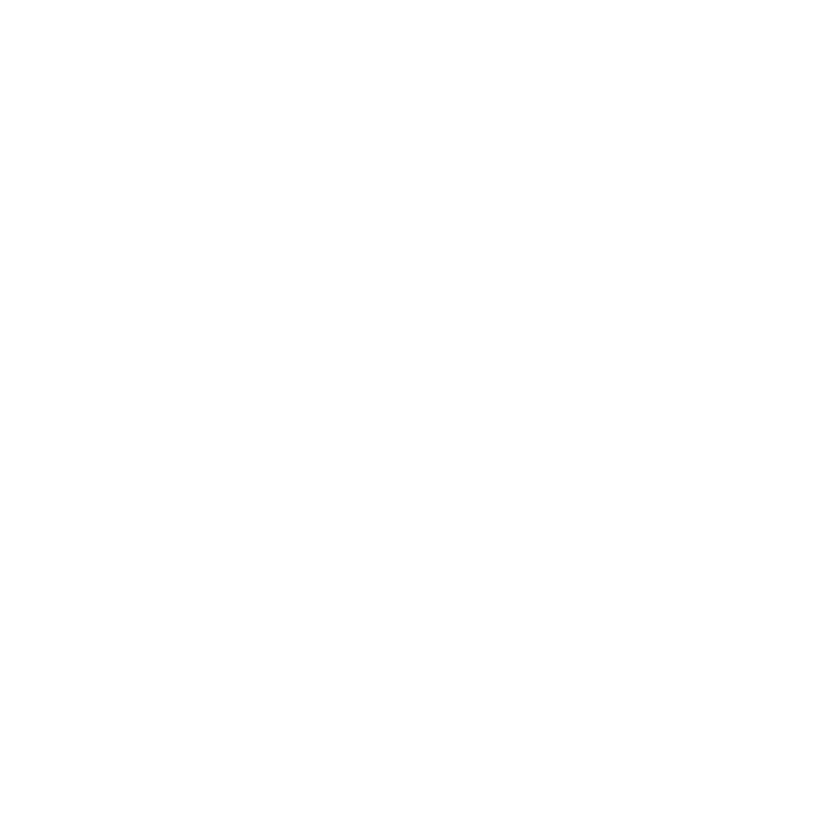

In [26]:
#tiff("BioEnr_go_fig1.tiff", units="in", width=8.95, height=6.05, res=300)
min_nonZero = min(clinical_analysis[, "nonZeroFacs"]) 
max_nonZero = max(clinical_analysis[, "nonZeroFacs"]) 
g <- ggplot(clinical_analysis, 
            aes(x=nonZeroFacs, y=selectivity)) + 
    geom_point(aes(colour = methods, shape = cancer), size=5, alpha=.6, position=position_jitter(h=0, w=0.15))+ 
    theme_bw() + 
    scale_shape_manual(values=c(15,17,16)) + 
    scale_color_manual(values=c('#FF00FF', '#FF6E28', '#C8961E', '#FF0000', '#0000FF', '#A0A0A0', '#48D1CC', '#00FF00')) +
    ylim(floor(min((clinical_analysis[,"selectivity"]*10)-.4)) / 10,
         ceiling(max((clinical_analysis[,"selectivity"]*10)+.2)) / 10) +
    labs(title="Clinical annotations", 
         x="# metagenes (factors) enriched in at least one annotation") +
    theme(plot.title = element_text(size=14,face="bold"),
          axis.text = element_text(size=11),
          axis.title = element_text(size=13),
          legend.text=element_text(size=10)) +
    ylab("Selectivity") + 
    labs(colour = "Methods",shape="Cancer") +
    guides(color = guide_legend(order = 1),shape = guide_legend(order = 2),size = guide_legend(order = 3)) + 
    #scale_x_discrete() + scale_x_discrete(limits=min_nonZero:max_nonZero) + 
    scale_x_discrete(limits=min_nonZero:max_nonZero, labels = c(min_nonZero:max_nonZero));
g
#dev.off()

ggsave(paste0(results_folder, "clinical_annotations.pdf"),dpi=300)
ggsave(paste0(results_folder, "clinical_annotations.png"),dpi=300) 